# Imports

In [1222]:
import time
import random
import osmnx as ox # OSMnx library for street networks using OpenStreetMap data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sns.set(
    {"figure.figsize": (17, 7)},
    style="ticks",
    palette=sns.color_palette("Set2"),
    color_codes=True,
    font_scale=0.8
)

%config InlineBackend.figure_format = "retina"

# Create graph

In [1193]:
start_coords = (53.472075, -2.238855)
target_coords = (53.47, -2.24)

In [1194]:
# Get data from open street maps and plot network
 
# See if data is already in RAM to save time when running in notebooks.
try:
    G
except NameError:
    G = ox.graph_from_point(start_coords, dist=2000, network_type="drive", simplify=True)

In [1195]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# General Node Class

In [1196]:
class Node():
    def __init__(self, node_id, cost_to_reach=np.nan, parent=None):
        self.node_id = node_id
        self.path_to_node = []
        self.cost_to_reach = cost_to_reach
        
        self.parent = parent

    def path_to(self):
        if self.parent is None: return []
        
        return self.parent.path_to() + [self.node_id]
                
    def __str__(self):
        return f"<class Node Object>, ID: {self.node_id}"
    
    def __repr__(self):
        return f"({self.__str__()})"
    
    def __eq__(self, other):
        # Compare equality based on the node_id
        if isinstance(other, Node):
            return self.node_id == other.node_id
        return False

    def __hash__(self):
        return hash(self.node_id)

# Setup

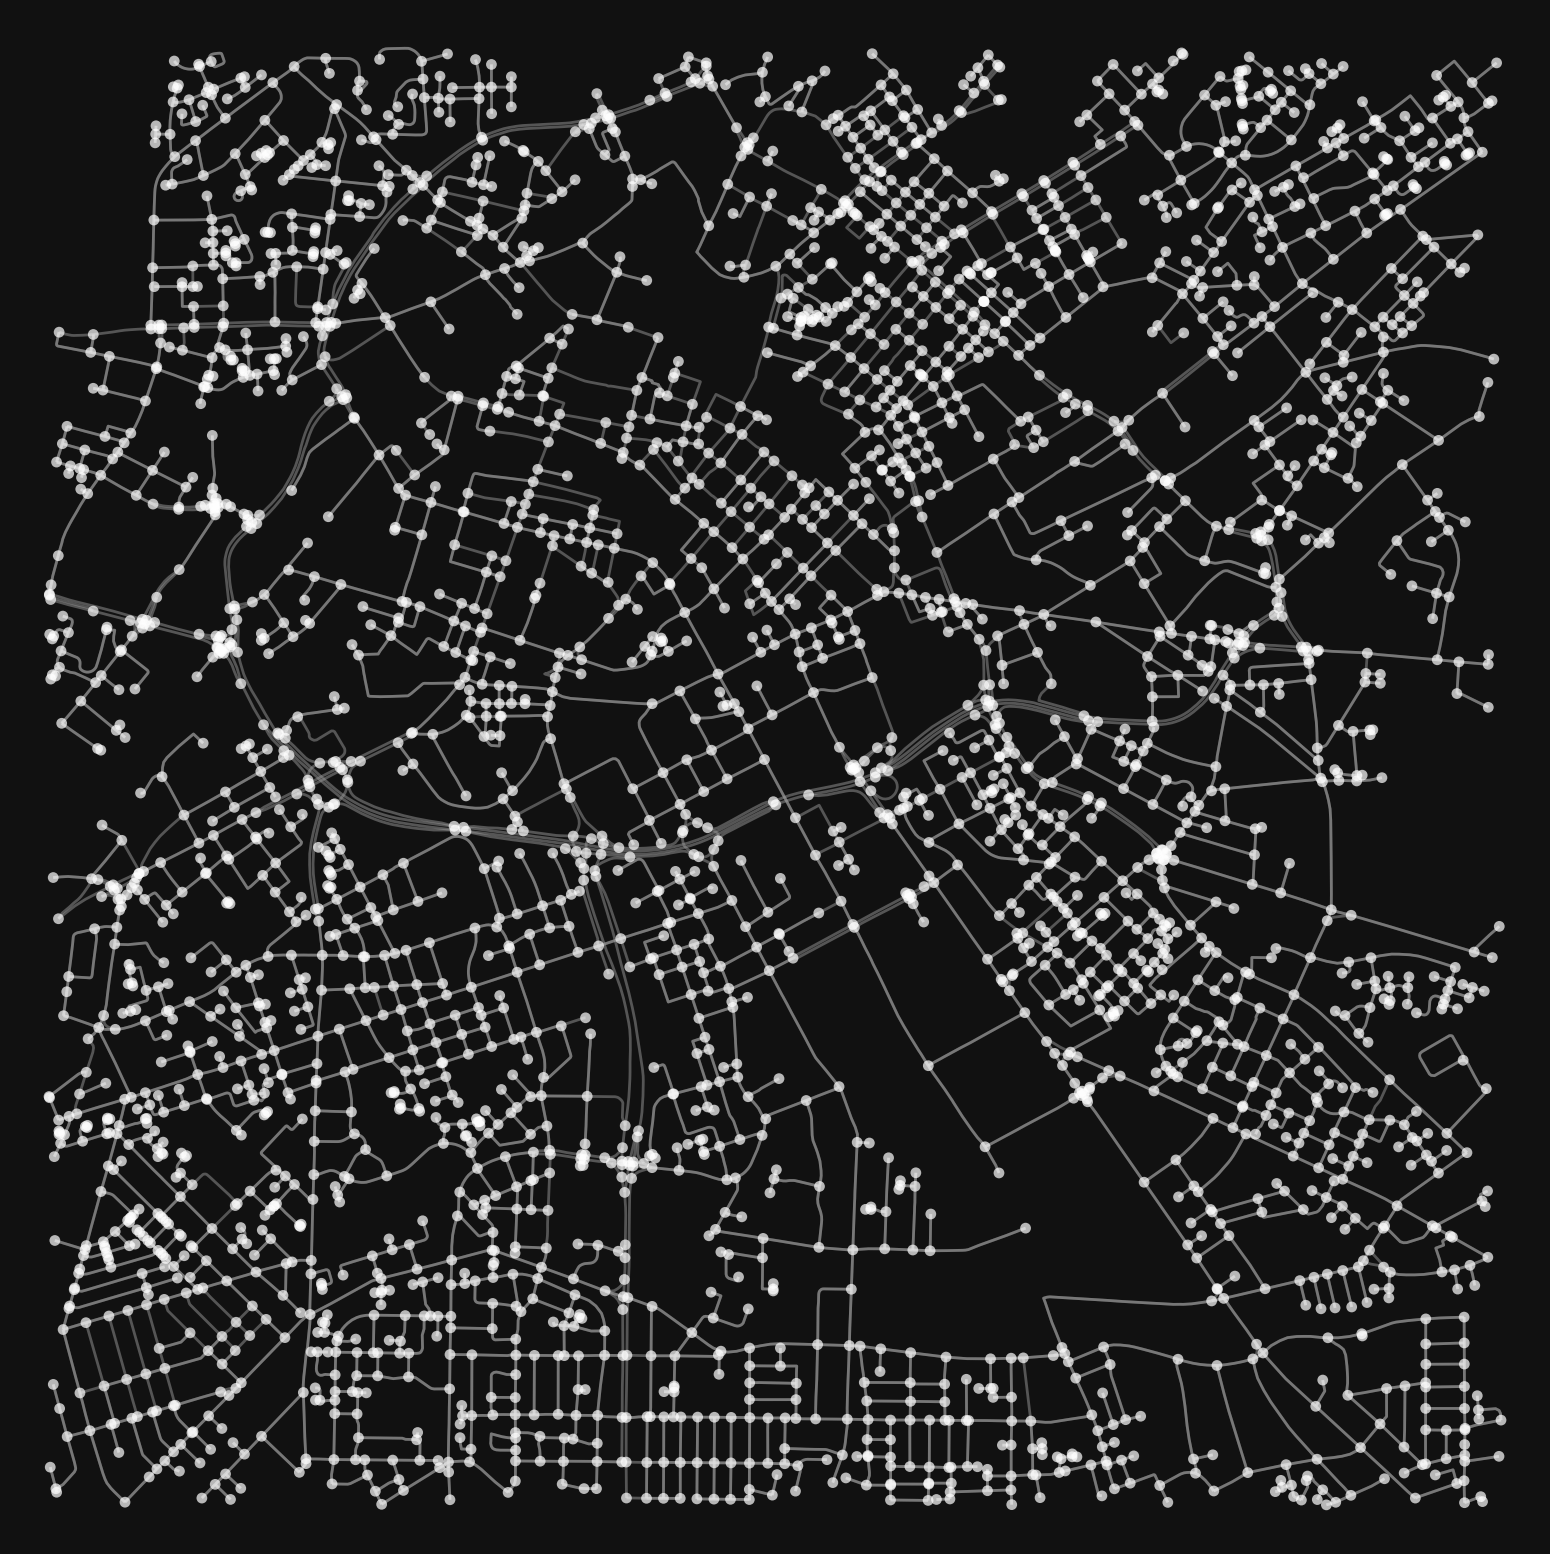

In [1197]:
# Setup plot
# ==========

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8),facecolor="#111111");
ax.set_facecolor("#111111")

# Remove margins
ax.margins(0)
plt.tight_layout(pad=0)

fig, ax, scatter = ox.plot_graph(G, ax=ax, node_alpha=0.7, edge_alpha=0.5);

In [1198]:
# Create list of nodes
nodes = [Node(node_id) for node_id in G.nodes()]

In [1199]:
num_points = len(nodes)

# Create a dictionary of adjacent node for look-up.
adj_dict = {n: list(adjacent_node_dict.keys()) for n, adjacent_node_dict in G.adjacency()}

# Visualising

In [1200]:
# Create a dictionary to map nodes to their index in a list
node_index_map = {nodes[i]: i for i in range(num_points)}

# Initially set sizes and colours to defaults (size 10, colour white)
sizes = [10 for i in range(num_points)]
colours = ["#FFFFFF" for i in range(num_points)] 

def update_graph_visuals(current_node, closed_set, destination_node):
    '''
    Function to update the sizes and colours of the nodes in the graph.
    '''
    
    # Loop through all closed (visited) nodes and set them to yellow and size 10
    if len(closed_set) > 1:
        sizes[node_index_map[closed_set[-2]]] = 10
        colours[node_index_map[closed_set[-2]]] = "#FFFF00"

    # Set destination node to size 30 and to purple colour 
    colours[node_index_map[destination_node]] = "#FF00FF"
    sizes[node_index_map[destination_node]] = 30
    
    # Set the current node to size 50 and to red colour
    sizes[node_index_map[current_node]] = 50
    colours[node_index_map[current_node]] = "#FF0000"
    
    # Update the sizes and colours of the nodes in the scatter plot.
    scatter.set_sizes(sizes)
    scatter.set_color(colours)

    return scatter

# Searching

In [1201]:
from sklearn.impute import SimpleImputer

for i in range (len(gdf_edges)):
    if type(gdf_edges.iloc[i]["maxspeed"]) == list:
        gdf_edges.iat[i, 2] = (float(gdf_edges.iloc[i]["maxspeed"][0][:-3]) + float(gdf_edges.iloc[i]["maxspeed"][1][:-3])) / 2


gdf_edges.loc[gdf_edges["maxspeed"].notna(), "maxspeed"] = gdf_edges.loc[gdf_edges["maxspeed"].notna(), "maxspeed"].map(lambda f: float(str(f)[:-3]))

imputer = SimpleImputer()
gdf_edges[["maxspeed"]] = imputer.fit_transform(gdf_edges[["maxspeed"]])

In [1202]:
def time_between(start_node_id, end_node_id):
    try:
        speed = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")["maxspeed"].item()
        distance = gdf_edges.xs(start_node_id, level="u").xs(end_node_id, level="v")["length"].item()
        return distance * speed
    except KeyError:
        return 0

In [1203]:
class SearchClass:
    def __init__(self, start_node, destination_node):
        self.start = start_node
        self.destination = destination_node
        self.done = False

        self.open = [start_node]
        self.closed = []

        self.current_node = start_node

    def reset(self):
        self.done = False
        self.open = [self.start]
        self.closed = []

    def run_search(self, search_type):
        while not self.done:
            self.search_step(search_type=search_type)

    def search_step(self, search_type):       
        next_node = self.pick_node(search_type)
        # next_node.cost_to_reach = self.current_node.cost_to_reach + time_between(self.current_node.node_id, next_node.node_id)
        self.done = (next_node == self.destination)
        self.open.extend([Node(node_id, parent=next_node) for node_id in adj_dict[next_node.node_id] if Node(node_id) not in self.closed])
        self.closed.append(next_node)
        self.current_node = next_node

        return next_node
    
    def pick_node(self, search_type):
        if search_type == "dfs":
            return self.open.pop(-1)
        if search_type == "bfs":
            return self.open.pop(0)
        

In [1204]:
class SearchClass(SearchClass):
    def animate_search(self, search_type):
        # Animation function
        def animate(frame):
            next_node = self.search_step(search_type)
            update_graph_visuals(next_node, self.closed, self.destination)
            return scatter
        
        # Frame generator: Stops yielding when .done
        def frame_generator():
            frame = 0
            while not self.done:
                yield frame
                frame += 1

        # Create the animation using the generator
        ani = animation.FuncAnimation(fig, animate, frames=frame_generator, interval=1, save_count=num_points)

        # Save the animation
        ffmpeg_writer = animation.FFMpegWriter(fps=5)
        print(f"Saving output to {search_type + "_manchester.mp4"}.")
        ani.save(search_type + "_manchester.mp4", writer=ffmpeg_writer)

    def display_final(self):
        if len(self.closed) <= 0:
            raise Exception("Must execute run_search method before displaying.")
        
        path = self.closed[-1].path_to()
    
        # Get node coordinates from the graph
        node_x = [G.nodes[node.node_id]['x'] for node in nodes]
        node_y = [G.nodes[node.node_id]['y'] for node in nodes]

        # Set default sizes and colors
        sizes = [5 for _ in range(num_points)]
        colours = ["#DDDDDD" for _ in range(num_points)] 

        # Extract start and destination node positions
        start_x, start_y = G.nodes[self.start.node_id]['x'], G.nodes[self.start.node_id]['y']
        dest_x, dest_y = G.nodes[self.destination.node_id]['x'], G.nodes[self.destination.node_id]['y']

        # Create the figure and axis
        fig, ax = plt.subplots(figsize=(7, 7), facecolor="#111111")
        ax.set_facecolor("#111111")
        ax.axis('off')

        # Plot all edges (graph edges) in grey
        for u, v, data in G.edges(data=True):
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#777777", alpha=1, lw=1, zorder=1)

        # Highlight path edges
        full_path = [self.start.node_id] + path  # Include start node explicitly
        for i in range(len(full_path) - 1):  # Iterate through consecutive nodes in the path
            u, v = full_path[i], full_path[i + 1]
            x_coords = [G.nodes[u]['x'], G.nodes[v]['x']]
            y_coords = [G.nodes[u]['y'], G.nodes[v]['y']]
            ax.plot(x_coords, y_coords, color="#FFFF00", lw=2.5, alpha=1, zorder=3)  # Highlighted path edges

        # Plot all other nodes with default sizes and colors
        ax.scatter(node_x, node_y, s=sizes, c=colours, zorder=2)

        # Plot nodes on the path (optional, to show nodes on the path more clearly)
        for node_id in path:
            x, y = G.nodes[node_id]['x'], G.nodes[node_id]['y']
            ax.scatter(x, y, s=5, c="#FFFF00", zorder=4)

        # Plot the start node on top (in red)
        ax.scatter(start_x, start_y, s=50, c="#FF0000", label="Start", zorder=5)

        # Plot the destination node on top (in purple)
        ax.scatter(dest_x, dest_y, s=50, c="#FF00FF", label="Destination", zorder=5)

        # Add legend for clarity (optional)
        ax.legend(facecolor="#222222", labelcolor="#FFFFFF", loc="upper right")

        plt.show()

# Running

In [1205]:
# Start at the Dalton Building
start_node = Node(ox.distance.nearest_nodes(G, Y=start_coords[0], X=start_coords[1]), cost_to_reach=0)

# Destination
destination_node = random.choice(nodes)

In [1206]:
searcher = SearchClass(start_node, destination_node)

In [1207]:
# searcher.run_search(search_type="bfs")
# searcher.display_final()

In [1208]:
# searcher.reset()
# searcher.animate_search(search_type="bfs")
# searcher.reset()
# searcher.animate_search(search_type="dfs")

<div style="display: flex;">
  <div style="flex: 50%;">
        <h1>Breadth First
        <br>
        <video src="bfs_manchester.mp4" alt="bfs" width="500" controls/>
    </div>

  <div style="flex: 50%;">
        <h1>Depth First
        <br>
        <video src="dfs_manchester.mp4" alt="dfs" width="501" controls/>
    </div>
</div>


# Evaluation

In [1209]:
def euclid_distance(start_node, end_node):
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return ((x_start - x_end)**2 + (y_start - y_end)**2)**0.5

def manhattan_distance(start_node, end_node):
    x_start, y_start = G.nodes[start_node.node_id]['x'], G.nodes[start_node.node_id]['y']
    x_end, y_end = G.nodes[end_node.node_id]['x'], G.nodes[end_node.node_id]['y']

    return abs(x_start - x_end) + abs(y_start - y_end)

In [1210]:
distances = []
bfs_times = []
dfs_times = []

for i in range(200):
    n_iterations = 3
    bfs_durations = np.zeros(n_iterations)
    dfs_durations = np.zeros(n_iterations)

    start = start_node
    end = random.choice(nodes)

    searcher = SearchClass(start_node, end)

    for n in range(n_iterations):
        searcher.reset()
        start_time = time.time_ns()
        searcher.run_search(search_type="bfs")
        bfs_durations[n] = time.time_ns() - start_time

    for n in range(n_iterations):
        searcher.reset()
        start_time = time.time_ns()
        searcher.run_search(search_type="dfs")
        dfs_durations[n] = time.time_ns() - start_time

    bfs_times.append(bfs_durations.mean()/1e6)
    dfs_times.append(dfs_durations.mean()/1e6)
    distances.append(euclid_distance(start, end))

In [ ]:
# # Create a DataFrame
# data = {
#     "Distance": distances,
#     "BFS_Time": bfs_times,
#     "DFS_Time": dfs_times,
# }
# df = pd.DataFrame(data)
# df = df.sort_values(by="Distance")
# df = df.reset_index(drop=True)
# df = df.melt(id_vars="Distance", var_name="Algorithm", value_name="Time")
# df.to_csv("dfs_bfs_200_times.csv")
# df.head()

In [1263]:
df = pd.read_csv("dfs_bfs_200_times.csv")

In [1258]:
from scipy.stats import zscore

# Calculate z-scores
df["z_score"] = zscore(df["Time"])

# Filter out rows with high z-scores (e.g., > 3 or < -3)
df_cropped = df[df["z_score"].abs() <= 0.5]

print(f"Original size: {len(df)}, Filtered size: {len(df_cropped)}")

Original size: 400, Filtered size: 387


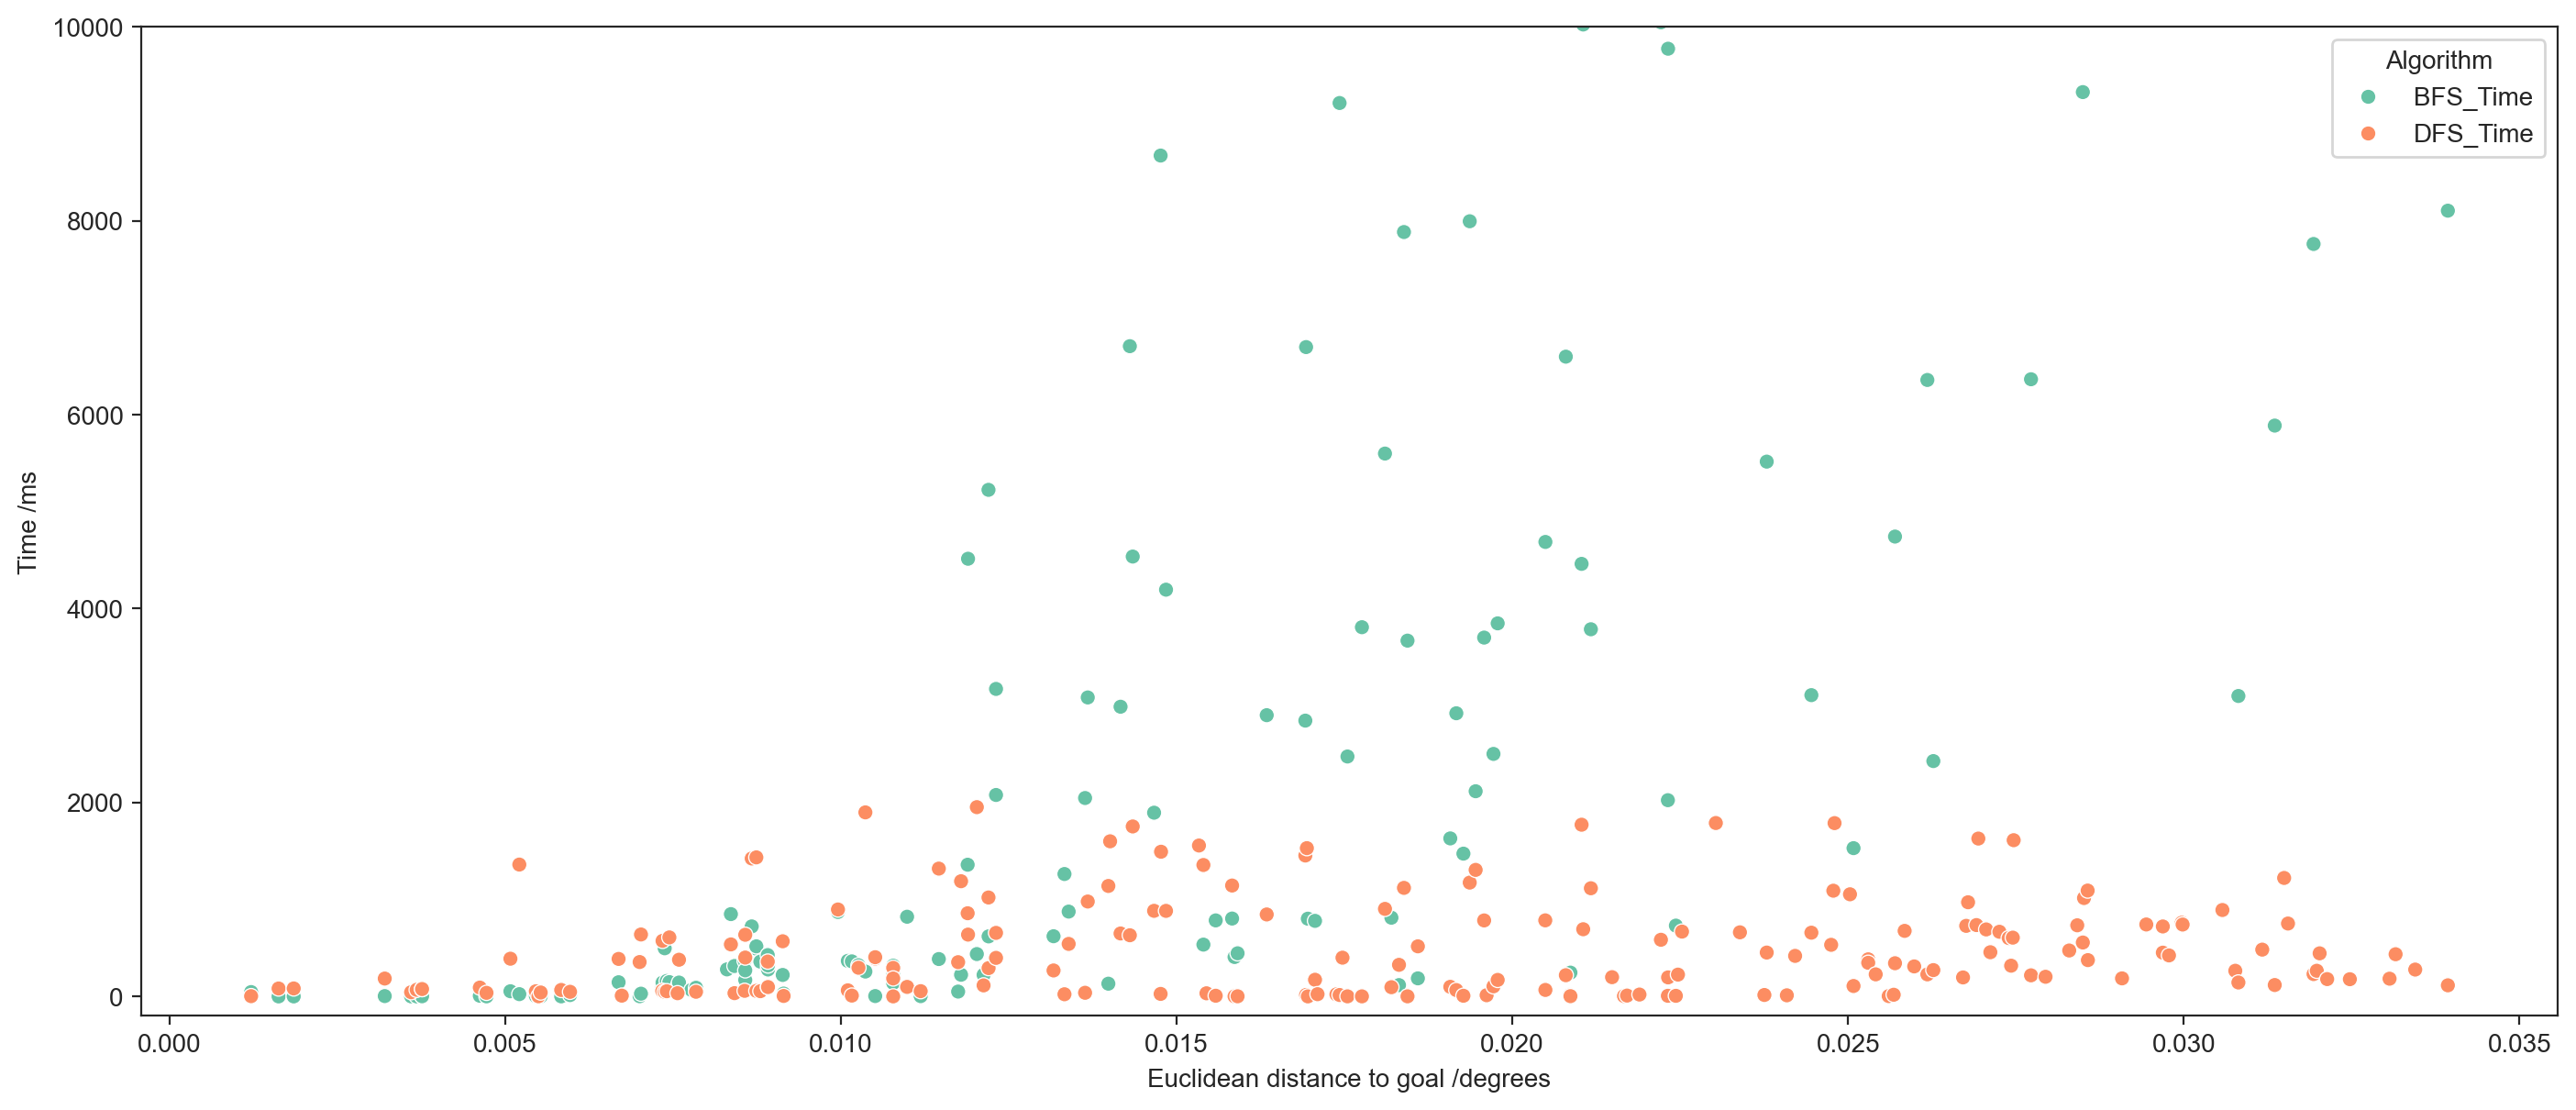

In [1259]:
sns.scatterplot(data=df_cropped, x="Distance", y="Time", hue="Algorithm")
plt.ylim(-2e2, 1e4)
plt.xlabel("Euclidean distance to goal /degrees")
plt.ylabel("Time /ms");

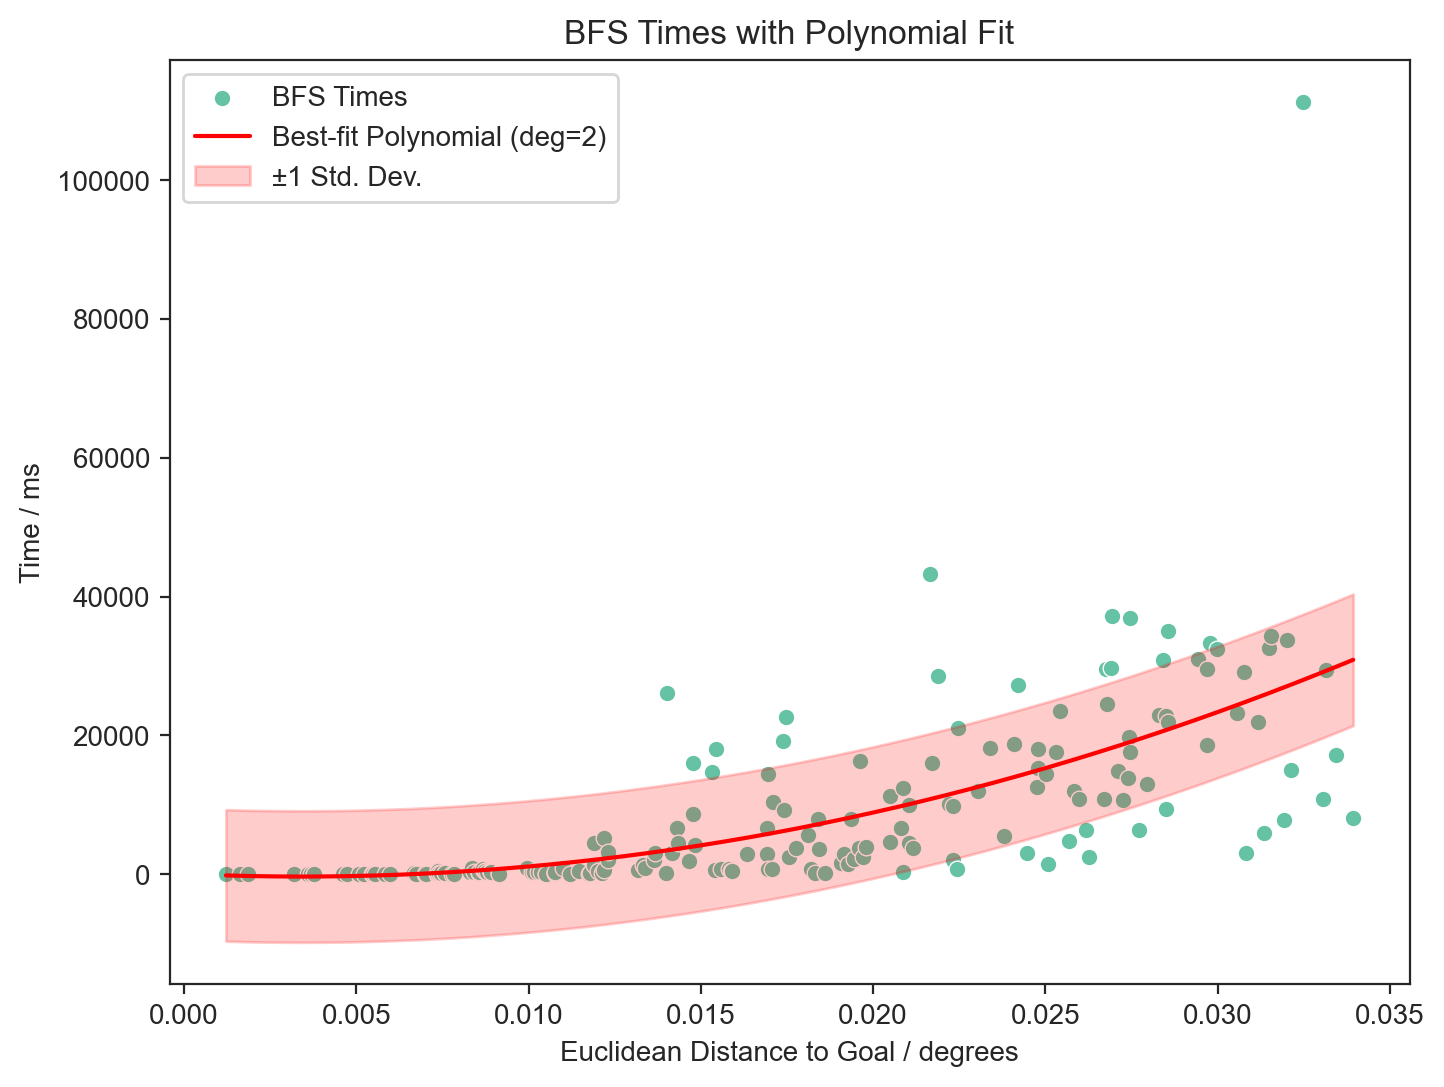

In [1264]:
df_cropped_bfs = df_cropped.loc[df_cropped["Algorithm"]=="BFS_Time"]

distances = df_cropped_bfs["Distance"].values  # Extract distances as a NumPy array
bfs_times = df_cropped_bfs["Time"].values  # Extract BFS times as a NumPy array

# Fit a polynomial (degree 2)
degree = 2
coeffs = np.polyfit(distances, bfs_times, degree)
poly_fit = np.poly1d(coeffs)

# Generate the best-fit line
fit_line = poly_fit(distances)

# Calculate errors (residuals)
errors = bfs_times - fit_line

# Plot the data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=distances, y=bfs_times, label="BFS Times")

# Plot the best-fit line
x_fit = np.linspace(distances.min(), distances.max(), 500)  # Smooth line
y_fit = poly_fit(x_fit)
plt.plot(x_fit, y_fit, label="Best-fit Polynomial (deg=2)", color="red")

# Plot error region (±1 standard deviation)
std_dev = np.std(errors)
plt.fill_between(
    x_fit,
    y_fit - std_dev,
    y_fit + std_dev,
    color="red",
    alpha=0.2,
    label="±1 Std. Dev."
)

# Labels and legend
plt.xlabel("Euclidean Distance to Goal / degrees")
plt.ylabel("Time / ms")
plt.title("BFS Times with Polynomial Fit")
plt.legend()
plt.show()